<a href="https://colab.research.google.com/github/RonTeichner/IRASforBacteria/blob/main/IRAS_for_Bacteria_fn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IRAS for Bacteria - Ornstein-Uhlenbeck threshold process**

First we simulate the Ornstein-Uhlenbeck (OU) stochastic process for the cell-size division mechanism

$$
\begin{equation}
dc = \frac{\mu_c-c}{\tau_c}dt + \sqrt{2\frac{\sigma^2_c}{\tau_c}}dW
\end{equation}
$$
where the term $dW$ is an increment of a Wiener process and with $\mu_c=1\, \mathrm{[\mu m]}$, $\sigma_c=0.1\, \mathrm{[\mu m]}$ and $\tau_c$ is either $2,40$ or $200\, \mathrm{[min]}$. Initial conditions are $c(0) \sim N(\mu_c, \sigma_c^2)$.





In [ ]:
#!pip install torchsde
import torch
from torch import nn
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchsde
from scipy import interpolate

class SDE_1D(nn.Module):

    def __init__(self, mu_c, sigma_c, tau_c):
        super().__init__()
        self.mu_c = nn.Parameter(torch.tensor(mu_c), requires_grad=False)
        self.sigma_c = nn.Parameter(torch.tensor(sigma_c), requires_grad=False)
        self.tau_c = nn.Parameter(torch.tensor(tau_c), requires_grad=False)
        self.WienerGain = nn.Parameter(torch.sqrt(2*torch.pow(self.sigma_c, 2)/self.tau_c), requires_grad=False)
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, c):
        return (self.mu_c - c)/self.tau_c

    def g(self, t, c):
        return self.WienerGain*torch.ones_like(c)

mu_c, sigma_c = 1.0, 0.1 # [mu m]
tau_cs = [2, 40, 200] # [min]

batch_size, state_size = 100, 1
nGenerations = 100
nMinPerGeneration = 60.0
t_step, sim_duration = 1.0/60*10, nMinPerGeneration*nGenerations # [min]
sde_sizer = SDE_1D(mu_c, sigma_c, tau_cs[0])
sde_adder = SDE_1D(mu_c, sigma_c, tau_cs[1])
sde_timer = SDE_1D(mu_c, sigma_c, tau_cs[2])
ts = np.arange(0, sim_duration, t_step)
c0 = mu_c + sigma_c*torch.randn(batch_size, state_size)

sys.setrecursionlimit(5000)

with torch.no_grad():
    cs_sizer = torchsde.sdeint(sde_sizer, c0, torch.from_numpy(ts), adaptive=False, dt=0.1).cpu().numpy()
    cs_adder = torchsde.sdeint(sde_adder, c0, torch.from_numpy(ts), adaptive=False, dt=0.1).cpu().numpy()
    cs_timer = torchsde.sdeint(sde_timer, c0, torch.from_numpy(ts), adaptive=False, dt=0.1).cpu().numpy()



Let us view 3 OU processes from each $\tau_c$:

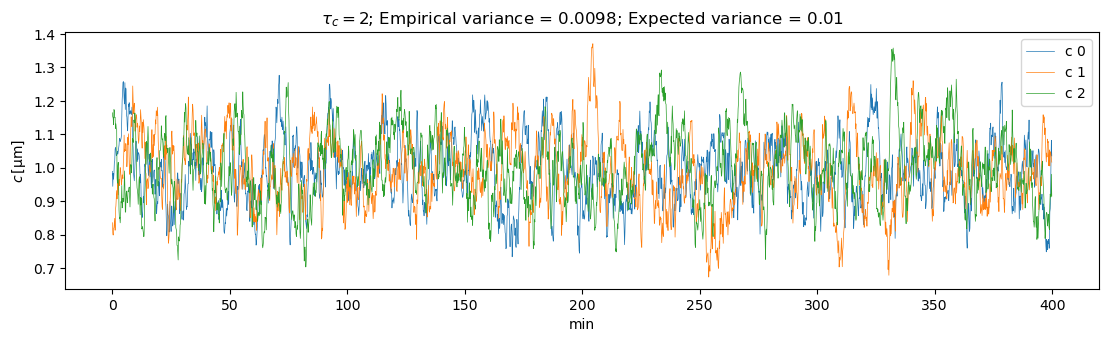

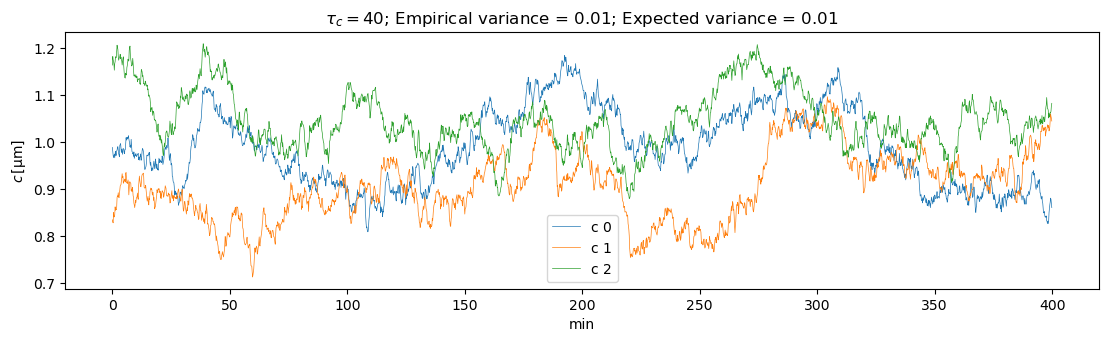

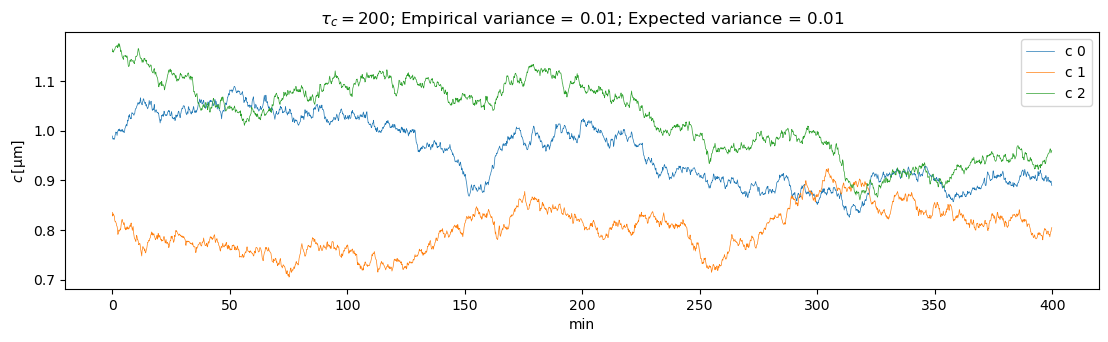

In [ ]:
def plot(ts, samples, xlabel, ylabel, title=''):
    samples = np.transpose(samples[:,:,0])
    plt.figure(figsize=(20/1.5,5/1.5))
    for i, sample in enumerate(samples):
        plt.plot(ts, sample[:len(ts)], linewidth = 0.5, label=f'c {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

nMin2Plot = 400
titleStr = r'$\tau_c=$' + f'{tau_cs[0]}; Empirical variance = {str(round(cs_sizer.flatten().var(), 4))}; Expected variance = {str(round(sigma_c**2,4))}'
plot(ts[:int(nMin2Plot/t_step)], cs_sizer[:,:3], xlabel='min', ylabel='$c\, \mathrm{[\mu m]}$', title=titleStr)

titleStr = r'$\tau_c=$' + f'{tau_cs[1]}; Empirical variance = {str(round(cs_adder.flatten().var(), 4))}; Expected variance = {str(round(sigma_c**2,4))}'
plot(ts[:int(nMin2Plot/t_step)], cs_adder[:,:3], xlabel='min', ylabel='$c\, \mathrm{[\mu m]}$', title=titleStr)

titleStr = r'$\tau_c=$' + f'{tau_cs[2]}; Empirical variance = {str(round(cs_timer.flatten().var(), 4))}; Expected variance = {str(round(sigma_c**2,4))}'
plot(ts[:int(nMin2Plot/t_step)], cs_timer[:,:3], xlabel='min', ylabel=r'$c\, \mathrm{[\mu m]}$', title=titleStr)

Next, we simulate lineages, each containing $100$ cells where the n<sup>th </sup> cell in the l<sup>th </sup> lineage ($n>0$) grows according to
$$
\begin{equation}
\begin{split}
x_n^{(l)}(t_{n,b}^{(l)} \leq t \leq t_{n,d}^{(l)}) &= x_{n,b}^{(l)} e^{\alpha_n (t-t_{n,b}^{(l)})}, \quad \alpha_n \sim \Gamma(25,9.4\cdot 10^{-4})\\
x_{n,b}^{(l)} &= x_{n-1}^{(l)}(t_{n-1,d}^{(l)})f_n, \quad f_n \sim N(0.5,0.05^2)\\
t_{n,b}^{(l)} &= t_{n-1,d}^{(l)}\\
t_{n,d}^{(l)} &= \begin{cases}\mathrm{argmin}_t\{t \geq t_{n,b}^{(l)} \mid x_{n,b}^{(l)} e^{\alpha (t-t_{n,b}^{(l)})} = c^{(l)}(t)\}, & \text{sizer mechanism}\\ \mathrm{argmin}_t\{t \geq t_{n,b}^{(l)} \mid x_{n,b}^{(l)} e^{\alpha (t-t_{n,b}^{(l)})}-x_{n,b}^{(l)} = c^{(l)}(t)\}, & \text{adder mechanism}\end{cases},
\end{split}
\end{equation}
$$
where $x_{n,b}^{(l)}\overset{\Delta}{=}x_n^{(l)}(t_{n,b}^{(l)})$ and the initial conditions for the first cell are
$$
\begin{equation}
\begin{split}
x_{0,b}^{(l)} &\sim N(0.5, 0.05^2), \quad
t_{0,b}^{(l)} = 0.
\end{split}
\end{equation}
$$
For each cell we save the features $(x_{n,b}^{(l)} ,x_{n,d}^{(l)}  ,T_n^{(l)} )\overset{\Delta}{=}(x_n^{(l)}(t_{n,b}^{(l)}), x_n^{(l)}(t_{n,d}^{(l)}), t_{n,d}^{(l)}-t_{n,b}^{(l)})$.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install numpy
import numpy as np
#print(f'{np.version.version}')
import pandas as pd
from IPython import display



def saveCSV(data, filename):
  completeFeatures = ['l0.0D','l1.0D','D']
  P, T, F = data.shape[0], data.shape[1], data.shape[2]
  df = pd.DataFrame(columns=["time","Id","batch"] + completeFeatures, data=np.zeros((P*T, 3+F)))
  tVec = np.arange(T)
  for p in range(P):
      specificID = data[p]
      df.loc[p*T:(p+1)*T-1,'time'] = tVec
      df.loc[p*T:(p+1)*T-1,'Id'] = p
      df.loc[p*T:(p+1)*T-1,'batch'] = 0
      df.iloc[p*T:(p+1)*T, 3:3+F] = specificID

  df.to_csv(filename)

def get_divisionTime(xb, t_xb, cs, ts, gamma_shape, gamma_scale, mechanismType):

  #alpha = 0.0235 + (0.0235*0.005)*np.random.randn()
  alpha = np.random.gamma(gamma_shape, gamma_scale)

  x = xb*np.exp(alpha*(ts - t_xb))
  if mechanismType == 'sizer':
    xd_plus_idx = np.where(x >= cs)[0][0]
  elif mechanismType == 'adder':
    xd_plus_idx = np.where(x-xb >= cs)[0][0]
  xd_plus, xd_minus = x[xd_plus_idx], x[xd_plus_idx-1]
  cs_plus, cs_minus = cs[xd_plus_idx], cs[xd_plus_idx-1]
  ts_plus, ts_minus = ts[xd_plus_idx], ts[xd_plus_idx-1]

  ts_highRes = np.arange(ts_minus, ts_plus, 1e-3)
  x_highRes = xd_minus*np.exp(alpha*(ts_highRes-ts_minus))
  cs_highRes = (cs_plus-cs_minus)/(ts_plus-ts_minus)*(ts_highRes-ts_minus) + cs_minus
  t_xd = ts_highRes[np.argmin(np.abs(cs_highRes-x_highRes))]
  xd = xb*np.exp(alpha*(t_xd - t_xb))

  return t_xd, xd

xb_0_mu, xb_0_sigma = 0.5, np.sqrt(0.0025)
f_mu = 0.5
f_sigma = 0.05*f_mu
gamma_shape, gamma_scale = 25, 9.4e-4

for mechanismType in ['adder', 'sizer']:
    for csi, cs_series in enumerate([cs_sizer, cs_adder, cs_timer]):
        observations = np.zeros((batch_size, int(nGenerations), 3)) # xb, xd, T
        for l in range(batch_size):
            display.clear_output(wait=True)
            print(mechanismType + f'; tau={tau_cs[csi]}; lineage {l}')
            single_cs_series = cs_series[:,l,0]
            for g in range(int(nGenerations)):
                if g == 0:
                    xbNegative = True
                    while xbNegative:
                        xb = xb_0_mu + xb_0_sigma*np.random.randn()
                        xbNegative = xb <= 0 or xb >= single_cs_series[0]
                    t_xb = 0.0
                else:
                    f_above_1 = True
                    while f_above_1:
                        f = f_mu + f_sigma*np.random.randn()
                        f_above_1 = f >= 1
                    xb = observations[l, g-1, 1]*f # \mu m
                    t_xb = observations[l, :g, 2].sum() # min
                t_xd, xd = get_divisionTime(xb, t_xb, single_cs_series, ts, gamma_shape, gamma_scale, mechanismType)
                observations[l, g] = np.array([xb, xd, t_xd - t_xb])
        if mechanismType == 'sizer':
            if csi == 0:
                observations_sizer = observations
                saveCSV(observations_sizer, './observations_sizer.csv')
            elif csi == 1:
                observations_adder = observations
                saveCSV(observations_adder, './observations_adder.csv')
            elif csi == 2:
                observations_timer = observations
                saveCSV(observations_timer, './observations_timer.csv')
        elif mechanismType == 'adder':
            if csi == 0:
                observations_adder_small_tau = observations
                saveCSV(observations_adder_small_tau, './observations_adder_small_tau.csv')
            elif csi == 1:
                observations_adder_medium_tau = observations
                saveCSV(observations_adder_medium_tau, './observations_adder_medium_tau.csv')
            elif csi == 2:
                observations_adder_high_tau = observations
                saveCSV(observations_adder_high_tau, './observations_adder_high_tau.csv')

sizer; tau=200; lineage 99


Let us view the OU threshold together with the lineages:

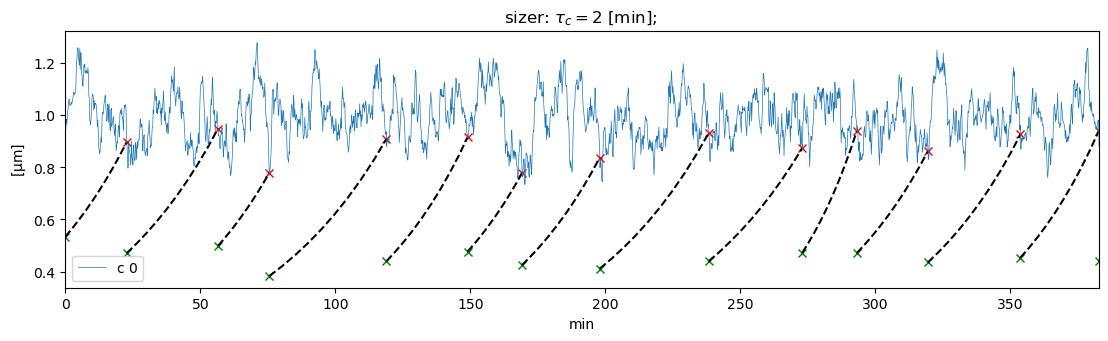

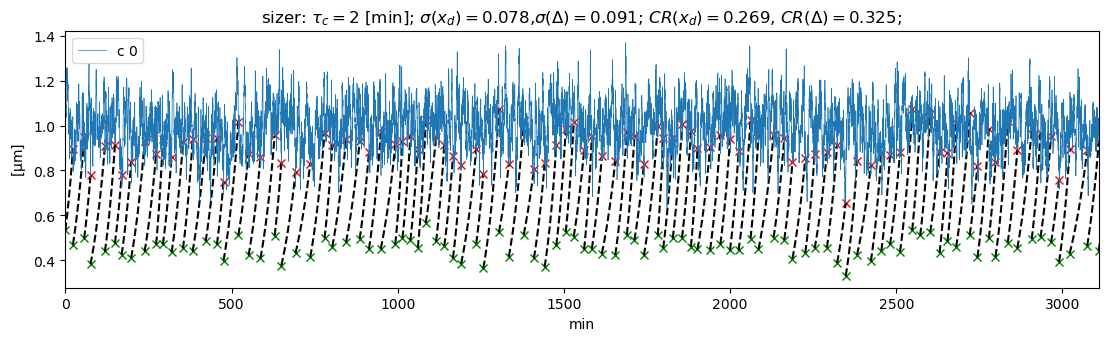

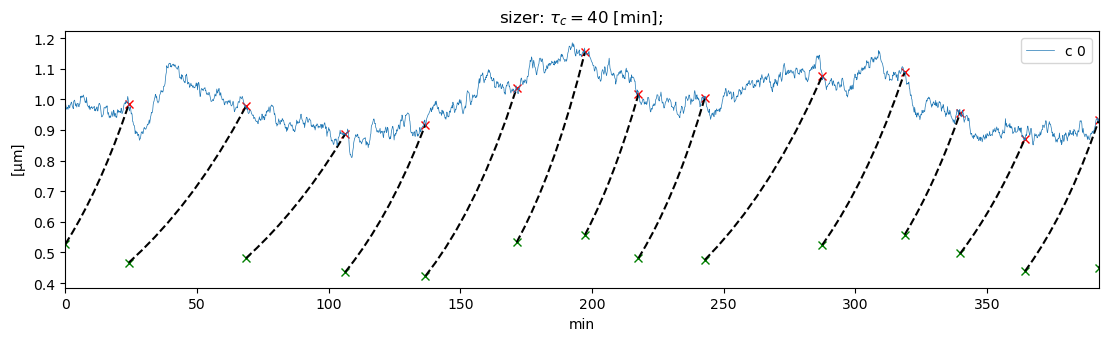

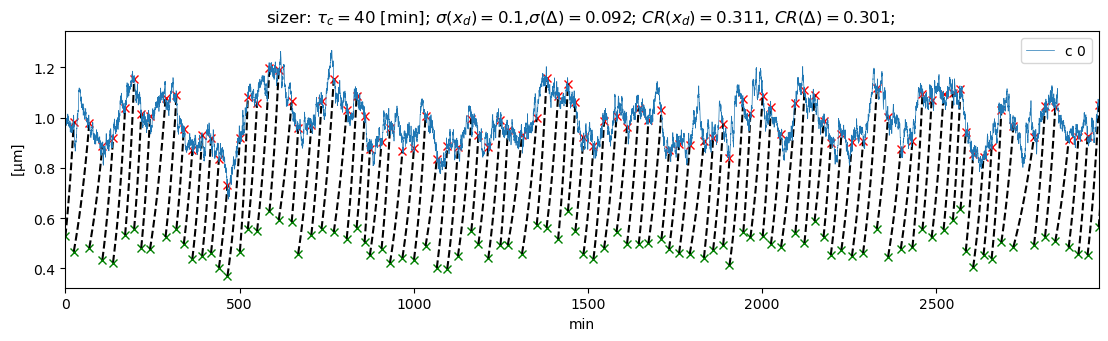

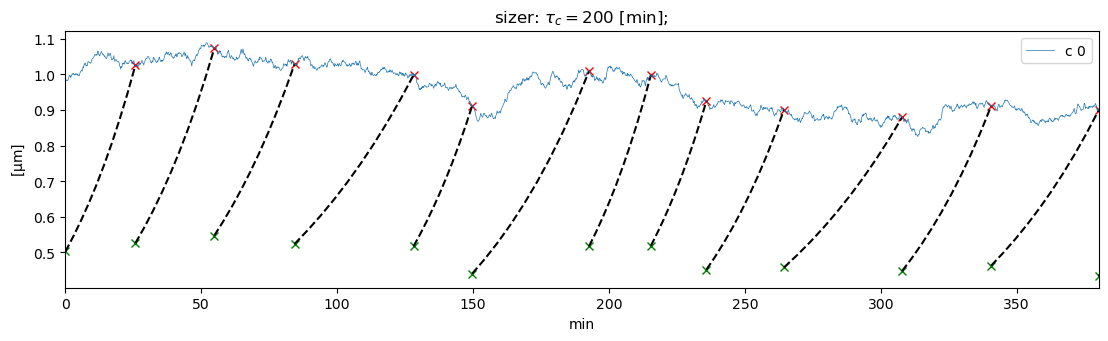

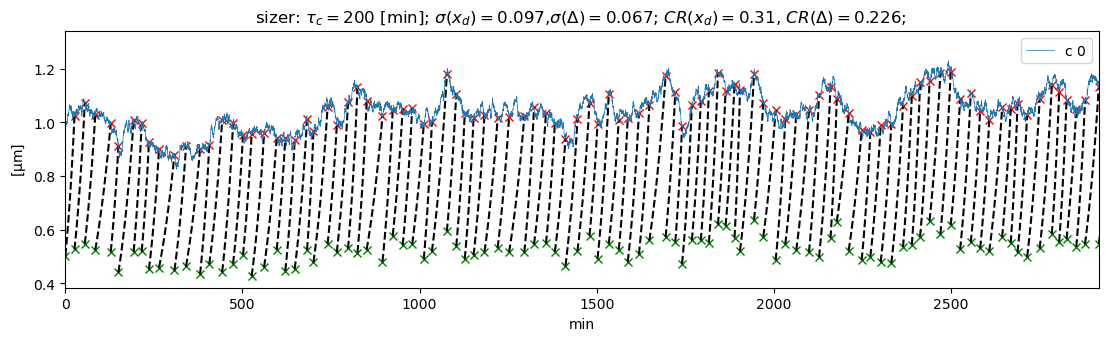

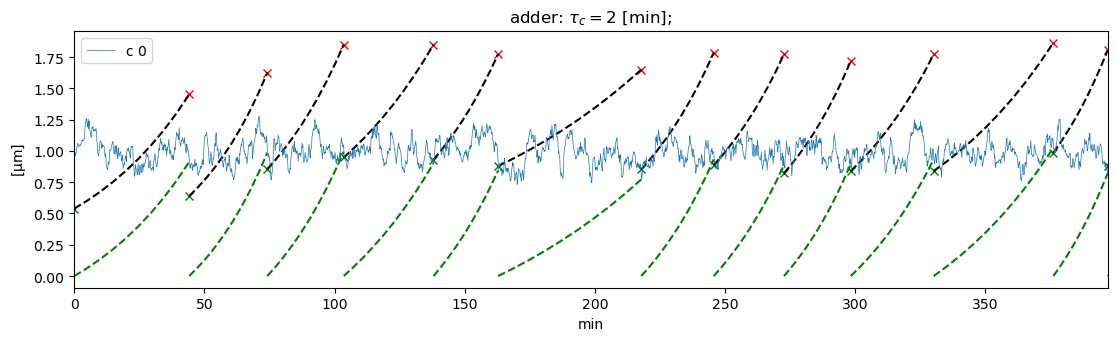

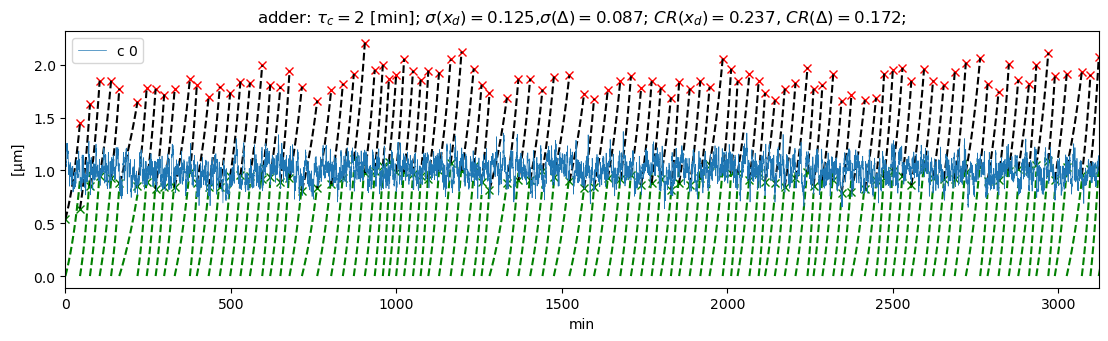

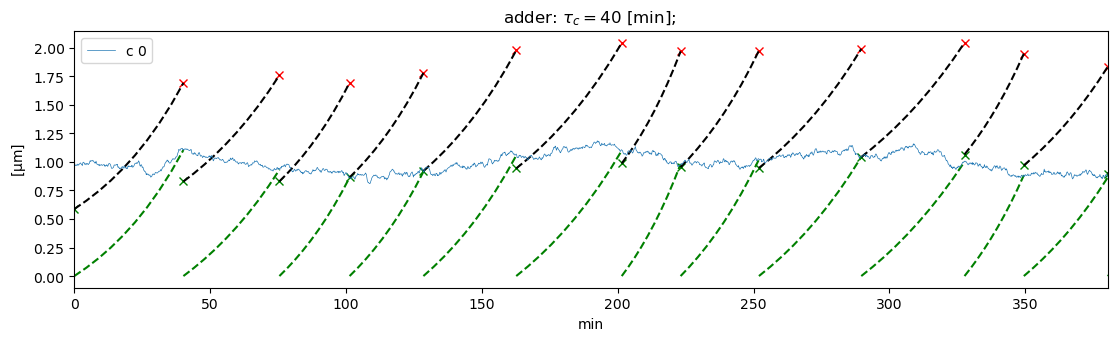

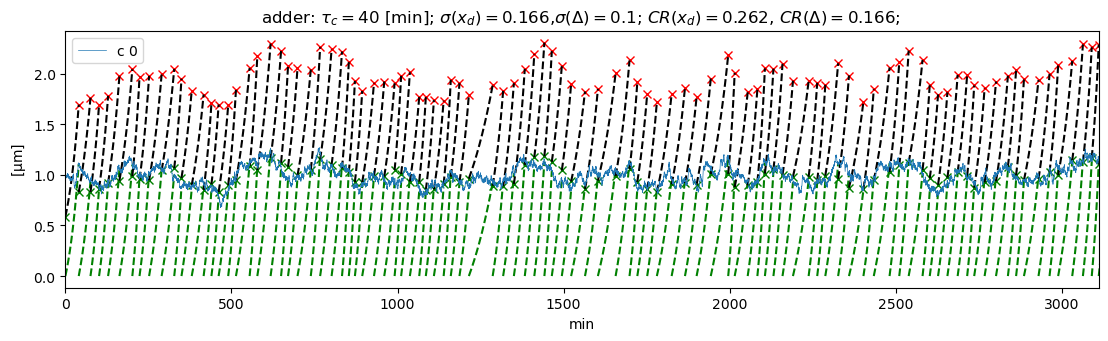

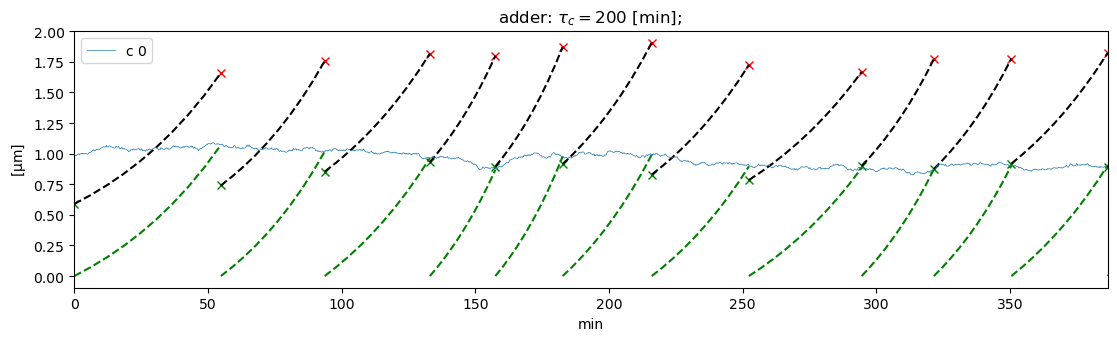

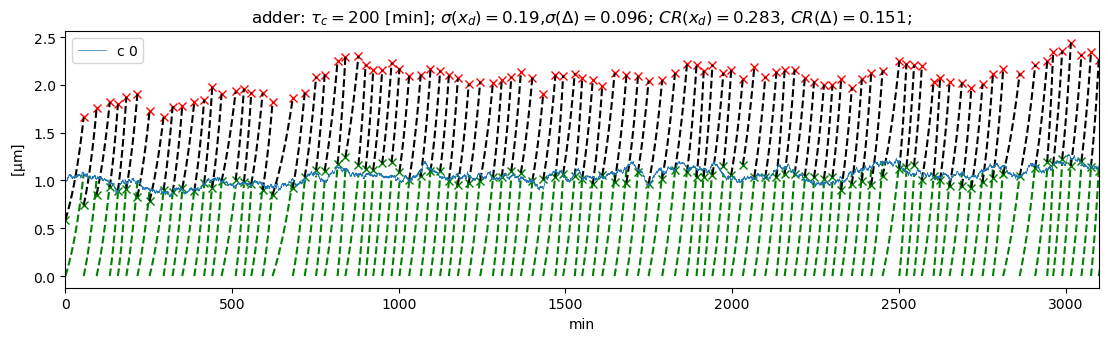

In [ ]:
def get_CR_str(observations):
  xb, xd = observations[:,:,0], observations[:,:,1]
  Delta = observations[:,:,1] - observations[:,:,0]
  T = observations[:,:,2]

  observations_alpha = observations.copy()
  observations_alpha[:,:,1] = 1/T*np.log(xd/xb)


  shuffledObservations_alpha = observations_alpha.copy()
  for p in range(shuffledObservations_alpha.shape[0]):
    for t in range(shuffledObservations_alpha.shape[1]):
      for f in range(shuffledObservations_alpha.shape[2]):
        shuffledObservations_alpha[p,t,f] = shuffledObservations_alpha[np.random.randint(shuffledObservations_alpha.shape[0]), np.random.randint(shuffledObservations_alpha.shape[1]), f]

  xb_shuffled, alpha_shuffled, T_shuffled = shuffledObservations_alpha[:,:,0], shuffledObservations_alpha[:,:,1], shuffledObservations_alpha[:,:,2]
  xd_shuffled = xb_shuffled*np.exp(alpha_shuffled*T_shuffled)
  Delta_shuffled = xd_shuffled - xb_shuffled

  CR_xd = xd.std()/xd_shuffled.std()
  CR_Delta = Delta.std()/Delta_shuffled.std()

  CR_str = r'; $CR(x_d)=$' + f'{str(round(CR_xd, 3))}' + r', $CR(\Delta)=$' + f'{str(round(CR_Delta, 3))}; '
  return CR_str

def plot_cs_and_lineage(ts, samples, observations, xlabel, ylabel, title='', mechanismType='sizer'):
    samples = np.transpose(samples[:,:,0])
    plt.figure(figsize=(20/1.5,5/1.5))
    for i, sample in enumerate(samples):
        singleLineageObservations = observations[i]
        t_xb = np.concatenate((np.zeros((1,)), singleLineageObservations[:,2].cumsum()))[:-1]
        t_xd = singleLineageObservations[:,2].cumsum()
        xb = singleLineageObservations[:,0]
        xd = singleLineageObservations[:,1]
        tIndices = t_xb < ts[-1]
        t_xb, t_xd, xb, xd = t_xb[tIndices], t_xd[tIndices], xb[tIndices], xd[tIndices]
        plt.plot(t_xb, xb, 'xg')
        plt.plot(t_xd, xd, 'xr')
        for t_xb_idx in range(len(t_xb)):
            T = t_xd[t_xb_idx] - t_xb[t_xb_idx]
            alpha = 1/T*np.log(xd[t_xb_idx]/xb[t_xb_idx])
            tVec = np.linspace(t_xb[t_xb_idx], t_xd[t_xb_idx], 10)
            xVals = xb[t_xb_idx]*np.exp(alpha*(tVec-tVec[0]))
            plt.plot(tVec, xVals, '--k')
            if mechanismType == 'adder':
                plt.plot(tVec, xVals-xb[t_xb_idx], '--g')
        plt.plot(ts, sample[:len(ts)], linewidth = 0.5, label=f'c {i}')
    plt.title(title)



    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([t_xb[0], t_xb[-1]])
    plt.legend()
    plt.show()

def getKuheliData(df):
    indices = np.where(df['birth size (um)']>0)[0]
    xb = df.iloc[indices]['birth size (um)'].to_numpy()
    T = df.iloc[indices]['division time (min)'].to_numpy()
    indices = np.where(df['division size (um)']>0)[0]
    xd = df.iloc[indices]['division size (um)'].to_numpy()
    return np.reshape(np.concatenate((xb[:,None], xd[:,None], T[:,None]), axis=1), (100,100,3))


runOnKuheliData = False
if runOnKuheliData:
    observations_sizer = getKuheliData(pd.read_csv('/Users/ron.teichner/Dropbox (Technion Dropbox)/KuheliBacteria/datasets for paper/Synthetic_data/cell size threshold: x(t)/cell_size_sizer.csv'))
    observations_adder = getKuheliData(pd.read_csv('/Users/ron.teichner/Dropbox (Technion Dropbox)/KuheliBacteria/datasets for paper/Synthetic_data/cell size threshold: x(t)/cell_size_adder.csv'))
    observations_timer = getKuheliData(pd.read_csv('/Users/ron.teichner/Dropbox (Technion Dropbox)/KuheliBacteria/datasets for paper/Synthetic_data/cell size threshold: x(t)/cell_size_timer.csv'))


sizerMechnismList = [observations_sizer, observations_adder, observations_timer]
adderMechanismList = [observations_adder_small_tau, observations_adder_medium_tau, observations_adder_high_tau]

for observationList,mechanismType in zip([sizerMechnismList, adderMechanismList], ['sizer', 'adder']):
    for observations, ouProcess, csi in zip(observationList, [cs_sizer, cs_adder, cs_timer], np.arange(len(tau_cs)).tolist()):
        titleStr = mechanismType + r': $\tau_c=$' + f'{tau_cs[csi]} [min]; '
        plot_cs_and_lineage(ts[:int(nMin2Plot/t_step)], ouProcess[:,:1], observations[:1], xlabel='min', ylabel='$\mathrm{[\mu m]}$', title=titleStr, mechanismType=mechanismType)
        titleStr = mechanismType + r': $\tau_c=$' + f'{tau_cs[csi]} [min]; ' + r'$\sigma(x_d)=$' + f'{str(round(observations[:,:,1].std(), 3))},' + r'$\sigma(\Delta)=$' + f'{str(round((observations[:,:,1]-observations[:,:,0]).std(), 3))}' + get_CR_str(observations)
        plot_cs_and_lineage(ts, ouProcess[:,:1], observations[:1], xlabel='min', ylabel='$\mathrm{[\mu m]}$', title=titleStr, mechanismType=mechanismType)



Analyzing the division mechanism using the $\Delta \overset{\Delta}{=} x_d-x_b$ vs $x_b$ correlation plot yields,

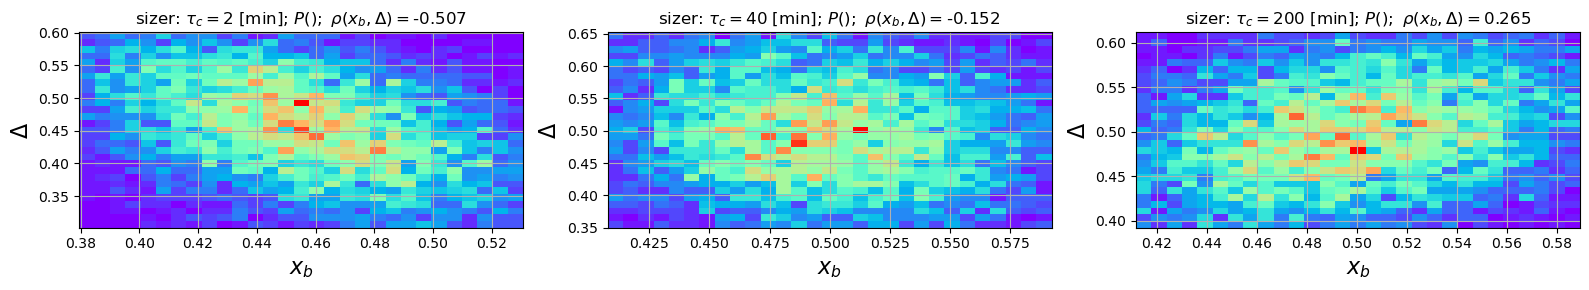

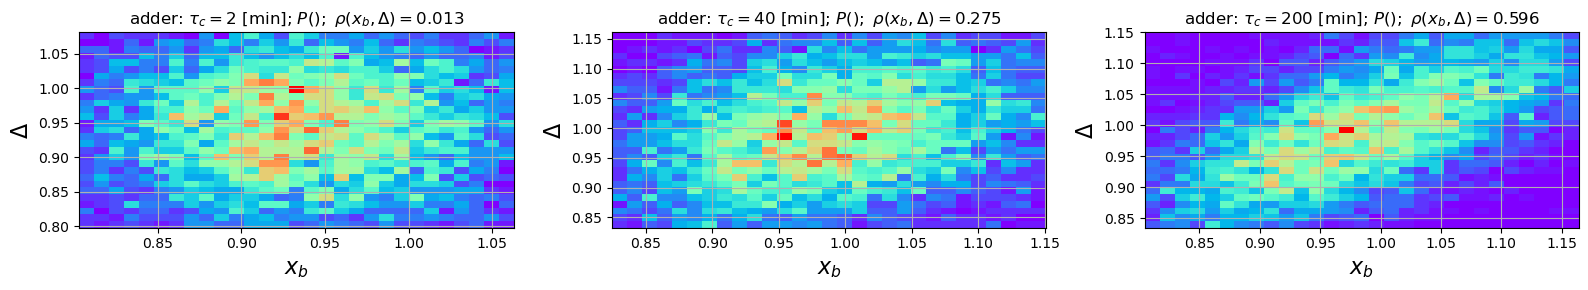

In [ ]:
import pandas as pd
axx,ab = 16/3, 9/3

sizerMechnismList = [observations_sizer, observations_adder, observations_timer]
adderMechanismList = [observations_adder_small_tau, observations_adder_medium_tau, observations_adder_high_tau]
for observationList, mechanismType in zip([sizerMechnismList, adderMechanismList], ['sizer', 'adder']):
    fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=False, figsize=(axx*3,ab*1))
    for i,observations in enumerate(observationList):
      ax = axs[i]
      xb, xd = observations[:,:,0].flatten(), observations[:,:,1].flatten()
      xbMin, xbMax = np.quantile(xb, 5/100), np.quantile(xb, 95/100)
      xd_Minus_xbMin, xd_Minus_xbMax = np.quantile(xd-xb, 5/100), np.quantile(xd-xb, 95/100)
      H, xedges, yedges = np.histogram2d(xb, xd-xb, bins=(np.linspace(xbMin, xbMax, 30), np.linspace(xd_Minus_xbMin, xd_Minus_xbMax, 30)), density=True)#, density=True)
      # Histogram does not follow Cartesian convention (see Notes),
      # therefore transpose H for visualization purposes.
      H = H.T
      X, Y = np.meshgrid(xedges, yedges)
      im = ax.pcolormesh(X, Y, H, cmap='rainbow')
      #ax.pcolormesh(xedges, yedges, H, cmap='rainbow')
      corr = pd.Series(xb).corr(pd.Series(xd-xb))
      ax.set_xlim([xbMin, xbMax])
      ax.set_ylim([xd_Minus_xbMin, xd_Minus_xbMax])
      ax.set_xlabel(r'$x_b$',fontsize=16)
      ax.set_ylabel(r'$\Delta$',fontsize=16)
      ax.set_title(mechanismType + r': $\tau_c=$' + f'{tau_cs[i]} [min]; ' + r'$P();$' + r' $\rho(x_b,\Delta)=$' + f'{str(round(corr, 3))}')
      #plt.colorbar(im)
      ax.grid()


    fig.tight_layout()
    plt.show()





And analyzing using mother-daughter correlation plots yields:

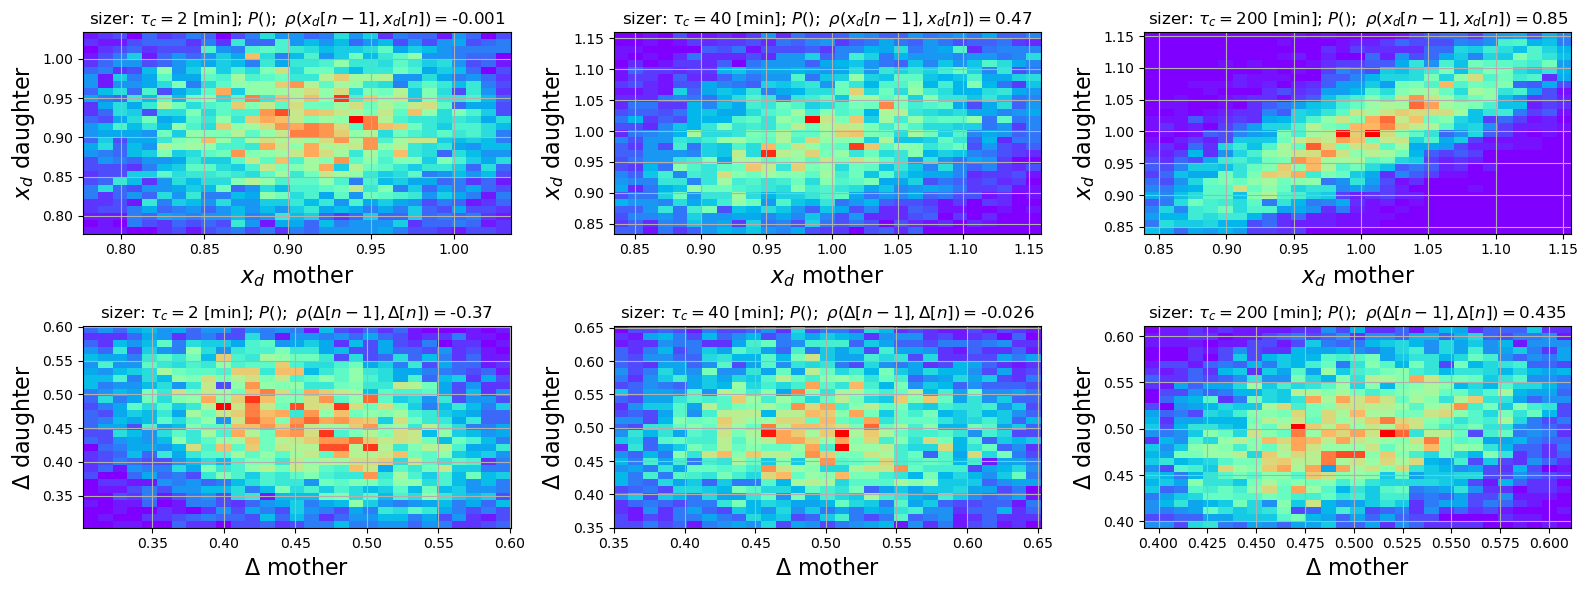

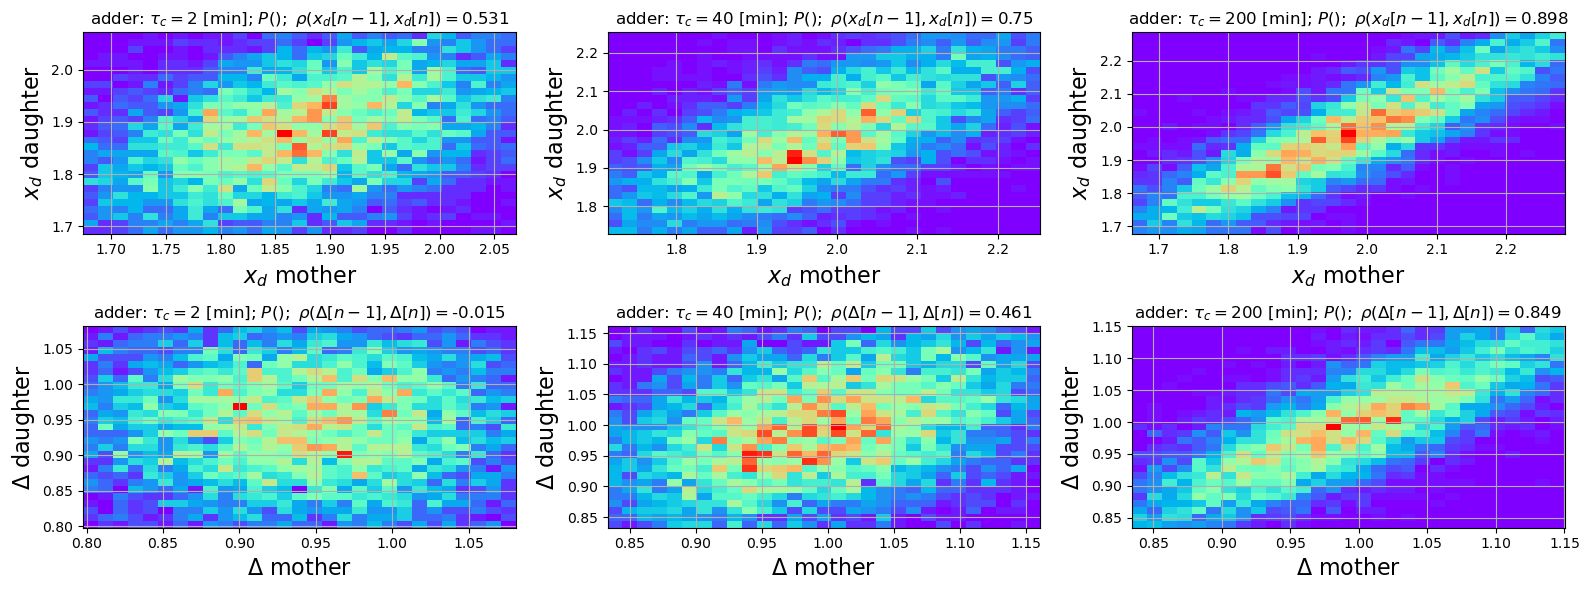

In [ ]:
for observationList, mechanismType in zip([sizerMechnismList, adderMechanismList], ['sizer', 'adder']):
    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=False, figsize=(axx*3,ab*2))
    for i,observations in enumerate(observationList):
        # calculate mother-daughter correlations:
        delta = observations[:,:,1:2] - observations[:,:,0:1]
        xd = observations[:,:,1:2]
        mother_daughter_delta = np.concatenate((delta[:, :-1], delta[:,1:]), axis=2)
        mother_daughter_xd = np.concatenate((xd[:, :-1], xd[:,1:]), axis=2)
        mother_delta, daughter_delta = mother_daughter_delta[:,:,0].flatten(), mother_daughter_delta[:,:,1].flatten()
        mother_xd, daughter_xd = mother_daughter_xd[:,:,0].flatten(), mother_daughter_xd[:,:,1].flatten()

        ax = axs[0,i]
        mother_xdMin, mother_xdMax = np.quantile(mother_xd, 5/100), np.quantile(mother_xd, 95/100)
        daughter_xdMin, daughter_xdMax = np.quantile(daughter_xd, 5/100), np.quantile(daughter_xd, 95/100)
        H, xedges, yedges = np.histogram2d(mother_xd, daughter_xd, bins=(np.linspace(mother_xdMin, mother_xdMax, 30), np.linspace(daughter_xdMin, daughter_xdMax, 30)), density=True)#, density=True)
        # Histogram does not follow Cartesian convention (see Notes),
        # therefore transpose H for visualization purposes.
        H = H.T
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X, Y, H, cmap='rainbow')
        #ax.pcolormesh(xedges, yedges, H, cmap='rainbow')
        corr = pd.Series(mother_xd).corr(pd.Series(daughter_xd))
        ax.set_xlim([mother_xdMin, mother_xdMax])
        ax.set_ylim([daughter_xdMin, daughter_xdMax])
        ax.set_xlabel(r'$x_d$ mother',fontsize=16)
        ax.set_ylabel(r'$x_d$ daughter',fontsize=16)
        ax.set_title(mechanismType + r': $\tau_c=$' + f'{tau_cs[i]} [min]; ' + r'$P();$' + r' $\rho(x_d[n-1],x_d[n])=$' + f'{str(round(corr, 3))}')
        #plt.colorbar(im)
        ax.grid()

        ax = axs[1,i]
        mother_deltaMin, mother_deltaMax = np.quantile(mother_delta, 5/100), np.quantile(mother_delta, 95/100)
        daughter_deltaMin, daughter_deltaMax = np.quantile(daughter_delta, 5/100), np.quantile(daughter_delta, 95/100)
        H, xedges, yedges = np.histogram2d(mother_delta, daughter_delta, bins=(np.linspace(mother_deltaMin, mother_deltaMax, 30), np.linspace(daughter_deltaMin, daughter_deltaMax, 30)), density=True)#, density=True)
        # Histogram does not follow Cartesian convention (see Notes),
        # therefore transpose H for visualization purposes.
        H = H.T
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X, Y, H, cmap='rainbow')
        #ax.pcolormesh(xedges, yedges, H, cmap='rainbow')
        corr = pd.Series(mother_delta).corr(pd.Series(daughter_delta))
        ax.set_xlim([mother_deltaMin, mother_deltaMax])
        ax.set_ylim([daughter_deltaMin, daughter_deltaMax])
        ax.set_xlabel(r'$\Delta$ mother',fontsize=16)
        ax.set_ylabel(r'$\Delta$ daughter',fontsize=16)
        ax.set_title(mechanismType + r': $\tau_c=$' + f'{tau_cs[i]} [min]; ' + r'$P();$' + r' $\rho(\Delta[n-1],\Delta[n])=$' + f'{str(round(corr, 3))}')
        #plt.colorbar(im)
        ax.grid()

    fig.tight_layout()
    plt.show()

We clearly see that although the division mechanism is a sizer, the different $\tau_c$ values affect the correlation plot and leads to false identification of the division mechanism (The color represents the 2D histogram values).

Next we analyze the division mechanism using the IRAS algorithm. For identifying the division mechanism we run IRAS on the transformed features, $z_n^{(l)} = \left(\frac{x_{n,b}^{(l)}}{x_{n-1,d}^{(l)}}, \alpha_n^{(l)} \overset{\Delta}{=} \frac{1}{T_n^{(l)}}\log\left(\frac{x_{n,d}^{(l)}}{x_{n,b}^{(l)}}\right),T_n^{(l)}\right)$.

## Define the neural-network $g(z)$ (combination player), the shuffle player and the Coefficient of Regulation loss
Next we define


1.   The combination player as a neural-network $g: \mathbb{R}^3 → \mathbb{R}$ that will output a combination $r = g(z)$ for each observation $z$.
2.   The shuffle player that assigns each element in the naive-shuffled ensemble $\bar{z}$ the probability of including it in the constrained-shuffled ensemble $\tilde{z}$. The shuffle player assigns the probability via the resampling function $\zeta(\cdot)$ such that it minimizes the objective,
$$
\begin{equation}
\begin{split}
&\min_{\zeta} D(P_z(g(z),P_{\tilde{z}}(g(\tilde{z})))\\
&\text{s.t } \tilde{z} \sim P_{\tilde{z}}(g(\tilde{z}))=P_{\bar{z}}(g(\tilde{z}))\zeta(g(\tilde{z}))
\end{split}
\end{equation}
$$
3.   The minimization objective of the combination player which is the Coefficient of Regulation with respect to the constrained shuffled ensemble,
$$
\begin{equation}
  min_g\frac{\sigma\left(r \sim P_z(g(z))\right)}{\sigma\left(\tilde{r} \sim P_{\tilde{z}}(g(\tilde{z})))\right)}.
\end{equation}
$$





In [ ]:
import torch
import torch.nn as nn


class Combination_ANN(nn.Module):
  def __init__(self, mu, Sigma_minus_half, features2ShuffleTogether, transform, playerPerPatient, learnThrProcess, dt):
        super(Combination_ANN, self).__init__()
        self.transform = transform
        self.learnThrProcess = learnThrProcess
        self.detachMode = True
        self.dt = dt
        if self.transform == 'randomMatrix':
          self.inputDim = 3*2
        else:
          self.inputDim = 3*3
        self.shuffleFactor = 100
        self.Sigma_minus_half = nn.parameter.Parameter(torch.tensor(Sigma_minus_half, dtype=torch.float), requires_grad=False)
        self.mu = nn.parameter.Parameter(torch.tensor(mu, dtype=torch.float), requires_grad=False)
        self.features2ShuffleTogetherLists = features2ShuffleTogether
        self.playerPerPatient = playerPerPatient
        self.shuffleCompleteDaughters = False
        '''
        self.sequence = nn.Sequential(nn.Linear(self.inputDim, 64),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(64, 32),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, 1),
                                                  nn.Sigmoid())
        '''
        if self.learnThrProcess:

            #self.timeUpdate = nn.Sequential(nn.Linear(1, 1))
            self.timeUpdate = nn.Sequential(nn.Linear(1, 32),
                                                      nn.LeakyReLU(),
                                                      #nn.Linear(64, 32),
                                                      #nn.ReLU(),
                                                      nn.Linear(32, 16),
                                                      nn.LeakyReLU(),
                                                      nn.Linear(16, 1),
                                                      nn.Sigmoid())






        self.sequence = nn.Sequential(nn.Linear(self.inputDim, 32),
                                                  nn.LeakyReLU(),
                                                  #nn.Linear(64, 32),
                                                  #nn.ReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, 1),
                                                  nn.Sigmoid())



  def shuffle(self, observations):
    naiveShuffledObservations = torch.zeros_like(observations)
    if self.shuffleCompleteDaughters:
        if not self.playerPerPatient:
            permuteSystemIdx = torch.randperm(observations.shape[0])#torch.randint_like(input=observations, low=0, high=observations.shape[0], dtype=torch.int64)
            permuteTimeIdx = torch.randperm(observations.shape[1])#torch.randint_like(input=observations, low=0, high=observations.shape[1], dtype=torch.int64)

            systemPermutedObservations = observations[permuteSystemIdx]#torch.gather(input=observations, dim=0, index=permuteSystemIdx)
            timeSystemPermutedObservations = systemPermutedObservations[:,permuteTimeIdx]#torch.gather(input=systemPermutedObservations, dim=1, index=permuteTimeIdx)
            naiveShuffledObservations[:,:] = timeSystemPermutedObservations[:,:]
    else:
        if not self.playerPerPatient:
          for features2ShuffleTogether in self.features2ShuffleTogetherLists:
            permuteSystemIdx = torch.randperm(observations.shape[0])#torch.randint_like(input=observations, low=0, high=observations.shape[0], dtype=torch.int64)
            permuteTimeIdx = torch.randperm(observations.shape[1])#torch.randint_like(input=observations, low=0, high=observations.shape[1], dtype=torch.int64)

            systemPermutedObservations = observations[permuteSystemIdx]#torch.gather(input=observations, dim=0, index=permuteSystemIdx)
            timeSystemPermutedObservations = systemPermutedObservations[:,permuteTimeIdx]#torch.gather(input=systemPermutedObservations, dim=1, index=permuteTimeIdx)
            naiveShuffledObservations[:,:,features2ShuffleTogether] = timeSystemPermutedObservations[:,:,features2ShuffleTogether]
        else:
          for s in range(observations.shape[0]):
            for features2ShuffleTogether in self.features2ShuffleTogetherLists:
              permuteIdx = torch.randperm(observations.shape[1])
              for f in features2ShuffleTogether:
                naiveShuffledObservations[s,:,f] = observations[s,permuteIdx,f]


    return naiveShuffledObservations

  def multipleShuffles(self, observations):
    naiveShuffledObservations = torch.zeros((observations.shape[0], int(observations.shape[1]*self.shuffleFactor), observations.shape[2]), dtype=torch.float, device=observations.device)
    for sf in range(self.shuffleFactor):
      naiveShuffledObservations[:,sf*observations.shape[1]:(sf+1)*observations.shape[1]] = self.shuffle(observations)
    return naiveShuffledObservations

  def normalizeObservations(self, observations):
    nSystem = observations.shape[0]
    nTime = observations.shape[1]
    means = self.mu[None, None, :, :].expand(nSystem, nTime, -1, -1)
    Sigma_minus_half = self.Sigma_minus_half[None, None, :, :].expand(nSystem, nTime, -1, -1)
    tilde_z = observations[:, :, :, None]
    nan_indices = tilde_z.isnan()
    tilde_z[nan_indices] = torch.zeros_like(tilde_z[nan_indices])
    normalized_tilde_z = torch.matmul(Sigma_minus_half, tilde_z - means)
    normalized_tilde_z[nan_indices] = torch.nan
    normalized_tilde_z = normalized_tilde_z[:,:,:, 0]

    return normalized_tilde_z

  def timeUpdateError(self, combination_daughter, combination_mother, observations_daughter):
    if self.transform == 'alpha_insteadOf_xd':
        T_daughter = observations_daughter[:,:,2:3]

    predicted_combination_daughter = torch.zeros_like(combination_daughter)
    tVec = torch.arange(0, 1.2*T_daughter.max(), self.dt, device=combination_daughter.device)
    nIters = int(1.1*T_daughter.max()/self.dt)

    if self.detachMode:
        combination_mother = combination_mother.detach()

    #predicted_combination_daughter = combination_mother + 2*(self.timeUpdate(combination_mother)-0.5)

    for t in range(nIters):
        #print(f'{t} out of {nIters}')
        #display.clear_output(wait=True)
        time = tVec[t]
        updateIndices = torch.abs(T_daughter-time) <= self.dt/2
        #print(f'shape of updateIndices {updateIndices.shape}')
        dc = (self.timeUpdate(combination_mother)-0.5)
        #print(f'shape of combination_mother {combination_mother.shape}')
        exactUpdate = (dc - dc/self.dt*(time-T_daughter))
        predicted_combination_daughter[updateIndices] = combination_mother[updateIndices] + exactUpdate[updateIndices]
        combination_mother = combination_mother + dc

    if self.detachMode:
        combination_daughter_error = combination_daughter.detach() - predicted_combination_daughter
    else:
        combination_daughter_error = combination_daughter - predicted_combination_daughter

    return combination_daughter_error, predicted_combination_daughter

  def forward(self, observations):
    combination_daughter_error, combination_shuffle_daughter_error = None, None
    combination_daughter, predicted_combination_daughter = None, None

    combination = self.sequence(self.normalizeObservations(observations))
    if self.learnThrProcess:
        observations_daughter = observations[:,1:]
        combination_daughter = combination[:,1:]
        combination_mother = combination[:,:-1]
        combination_daughter_error, predicted_combination_daughter = self.timeUpdateError(combination_daughter, combination_mother, observations_daughter)
        #print(f'T daughter mean, std = {observations_daughter[:,:,2].detach().cpu().numpy().mean()}, {observations_daughter[:,:,2].detach().cpu().numpy().std()}')
        #print(f'sys0: T daughter mean, std = {observations_daughter[0,:,2].detach().cpu().numpy().mean()}, {observations_daughter[0,:,2].detach().cpu().numpy().std()}')
        #print(f'error daughter mean, std = {combination_daughter_error.detach().cpu().numpy().mean()}, {combination_daughter_error.detach().cpu().numpy().std()}')
        #print(f'sys0: error daughter mean, std = {combination_daughter_error[0].detach().cpu().numpy().mean()}, {combination_daughter_error[0].detach().cpu().numpy().std()}')
        #print('')
    # shuffle:
    naiveShuffledObservations = self.multipleShuffles(observations)
    #print(f'naiveShuffledObservations T mean, std = {naiveShuffledObservations[:,:,2].detach().cpu().numpy().mean()}, {naiveShuffledObservations[:,:,2].detach().cpu().numpy().std()}')
    #print(f'sys0: naiveShuffledObservations T mean, std = {naiveShuffledObservations[0,:,2].detach().cpu().numpy().mean()}, {naiveShuffledObservations[0,:,2].detach().cpu().numpy().std()}')
    #print('')
    combinationOnNaiveShuffle = self.sequence(self.normalizeObservations(naiveShuffledObservations))

    if self.learnThrProcess:

        combination_shuffle_daughter_error, _ = self.timeUpdateError(combinationOnNaiveShuffle, combination.repeat(1,self.shuffleFactor,1), naiveShuffledObservations)
        #print(f'T shuffled daughter mean, std = {observations_shuffled_daughter[:,:,2].detach().cpu().numpy().mean()}, {observations_shuffled_daughter[:,:,2].detach().cpu().numpy().std()}')
        #print(f'sys0: shuffled T daughter mean, std = {observations_shuffled_daughter[0,:,2].detach().cpu().numpy().mean()}, {observations_shuffled_daughter[0,:,2].detach().cpu().numpy().std()}')
        #print(f'shuffled error daughter mean, std = {combination_shuffle_daughter_error.detach().cpu().numpy().mean()}, {combination_shuffle_daughter_error.detach().cpu().numpy().std()}')
        #print(f'sys0: shuffled error daughter mean, std = {combination_shuffle_daughter_error[0].detach().cpu().numpy().mean()}, {combination_shuffle_daughter_error[0].detach().cpu().numpy().std()}')

    return combination, combinationOnNaiveShuffle, naiveShuffledObservations, combination_daughter_error, combination_shuffle_daughter_error, (combination_daughter, predicted_combination_daughter)

def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to")

def shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient):

  device = combination.device
  combination, combinationOnNaiveShuffle = combination.detach(), combinationOnNaiveShuffle.detach()
  nBins = 50
  shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
  baseLength = combination.shape[1]
  nSystems = combination.shape[0]

  if not(playerPerPatient):
    comb_data_flatten, comb_shuffle_flatten = torch.zeros((0), dtype=torch.float, device=combination.device), torch.zeros((0), dtype=torch.float, device=combination.device)

    for p in range(nSystems):
        comb_data_flatten_singlePatient = combination[p, :, 0]
        comb_data_flatten = torch.cat((comb_data_flatten, comb_data_flatten_singlePatient))

        comb_shuffle_flatten_singlePatient = torch.zeros((0), dtype=torch.float, device=combination.device)
        for s in range(shuffleFactor):
            start = s*baseLength
            stop = start + baseLength
            comb_shuffle_flatten_singleShuffle = combinationOnNaiveShuffle[p, start:stop, 0]
            comb_shuffle_flatten_singlePatient = torch.cat((comb_shuffle_flatten_singlePatient, comb_shuffle_flatten_singleShuffle))
        comb_shuffle_flatten = torch.cat((comb_shuffle_flatten, comb_shuffle_flatten_singlePatient))


    min_range = comb_data_flatten.min()
    max_range = comb_data_flatten.max()

    bins = torch.linspace(min_range, max_range, nBins, device='cpu')
    prob_data = torch.histogram(comb_data_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]
    prob_shuffle = torch.histogram(comb_shuffle_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]

    binsDict = {'bins': bins, 'minVal': min_range, 'maxVal': max_range}
  else:
    binsDict, prob_data, prob_shuffle = list(), list(), list()
    for p in range(nSystems):
      comb_data_flatten_singleSystem = combination[p, :, 0]

      systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combination.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combination.device)[None, :].repeat(baseLength, 1)).flatten()
      comb_shuffle_flatten_singleSystem = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices)

      min_range = comb_data_flatten_singleSystem.min()
      max_range = comb_data_flatten_singleSystem.max()

      bins = torch.linspace(min_range, max_range, nBins, device='cpu')
      prob_data_patient = torch.histogram(comb_data_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]
      prob_shuffle_patient = torch.histogram(comb_shuffle_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]

      if prob_data_patient.isnan().any():
        prob_data.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
      else:
        prob_data.append(prob_data_patient)

      if prob_shuffle_patient.isnan().any():
        prob_shuffle.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
      else:
        prob_shuffle.append(prob_shuffle_patient)

      binsDict.append({'bins': bins, 'minVal': min_range, 'maxVal': max_range})


  prob_data, prob_shuffle, binsDict = move_to(prob_data, device), move_to(prob_shuffle, device), move_to(binsDict, device)
  combination, combinationOnNaiveShuffle = combination.to(device), combinationOnNaiveShuffle.to(device)
  combinationOnNaiveShuffle_selectionProb = torch.zeros_like(combinationOnNaiveShuffle)

  if not(playerPerPatient):
    bins, minVal, maxVal = binsDict['bins'], binsDict['minVal'], binsDict['maxVal']
    prob_select = torch.zeros_like(prob_data)
    posProbInx = prob_shuffle > 0
    #if not posProbInx.any():
    #    print(f'prob_shuffle is strickly zero')
    #else:
    #    print(f'prob_shuffle has {posProbInx.sum()} > 0 bins')
    prob_select[posProbInx] = prob_data[posProbInx]/prob_shuffle[posProbInx]
    prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()

    validIndices = torch.zeros_like(combinationOnNaiveShuffle, device=combinationOnNaiveShuffle.device).bool()

    for p in range(nSystems):
        lengthOfCurrentSeries = baseLength
        for s in range(shuffleFactor):
            start = s*baseLength
            stop = start + lengthOfCurrentSeries
            validIndices[p, start:stop] = True

    validIndices[combinationOnNaiveShuffle < minVal] = False
    validIndices[combinationOnNaiveShuffle > maxVal] = False

    bin_belong = torch.zeros_like(combinationOnNaiveShuffle, dtype=torch.long, device=combinationOnNaiveShuffle.device)
    for b in range(bins.shape[0]-1):
        bin_belong[combinationOnNaiveShuffle >= bins[b]] = b

    combinationOnNaiveShuffle_selectionProb = prob_select[bin_belong]
    combinationOnNaiveShuffle_selectionProb[torch.logical_not(validIndices)] = 0
  else:
    for p in range(nSystems):
      bins, minVal, maxVal = binsDict[p]['bins'], binsDict[p]['minVal'], binsDict[p]['maxVal']

      prob_select = torch.zeros_like(prob_data[p])
      posProbInx = prob_shuffle[p] > 0
      prob_select[posProbInx] = prob_data[p][posProbInx]/prob_shuffle[p][posProbInx]
      prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()

      validIndices = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], device=combinationOnNaiveShuffle.device).bool()

      for s in range(shuffleFactor):
        start = s*baseLength
        stop = start + baseLength
        validIndices[0, start:stop] = True

      validIndices[combinationOnNaiveShuffle[p:p+1] < minVal] = False
      validIndices[combinationOnNaiveShuffle[p:p+1] > maxVal] = False

      bin_belong = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], dtype=torch.long, device=combinationOnNaiveShuffle.device)

      for b in range(bins.shape[0]-1):
        bin_belong[combinationOnNaiveShuffle[p:p+1] >= bins[b]] = b

      combinationOnNaiveShuffle_selectionProb[p] = prob_select[bin_belong][0]
      combinationOnNaiveShuffle_selectionProb[p][torch.logical_not(validIndices)[0]] = 0

  return combinationOnNaiveShuffle_selectionProb

def CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb, playerPerPatient):
    #playerPerPatient = False
    shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
    baseLength = combination.shape[1]
    nSystems = combination.shape[0]
    totalSeriesLengths  = int(nSystems*baseLength)
    totalShuffleSeriesLengths  = totalSeriesLengths*shuffleFactor

    combinationStds, combinationOnShuffledStds, combinationOnNaiveShuffledStds = torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device)
    selectedShuffleCombinations = torch.zeros((0), dtype=torch.float, device=combination.device)

    combinationIndices = torch.zeros((totalSeriesLengths), dtype=torch.long, device=combination.device)
    systemCombinationsStartIdx = 0
    for p in range(nSystems):
        combinationIndices[systemCombinationsStartIdx:systemCombinationsStartIdx+baseLength] = torch.arange(baseLength) + baseLength*p
        systemCombinationsStartIdx += baseLength
    systemCombinations = torch.gather(combination.flatten(), 0, combinationIndices)
    naiveShuffleCombinations = torch.zeros((totalShuffleSeriesLengths), dtype=torch.float, device=systemCombinations.device)
    systemCombinationsStartIdx = 0

    totalSelected = 0
    for p in range(nSystems):
        systemCombination = combination[p:p + 1]
        systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[None, :].repeat(baseLength, 1)).flatten()
        systemShuffledCombinationProb = torch.gather(combinationOnNaiveShuffle_selectionProb[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
        systemShuffledCombination = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
        combinationStds[p] = systemCombination.std()
        naiveShuffleCombinations[systemCombinationsStartIdx:systemCombinationsStartIdx+systemShuffledCombination.shape[1]] = systemShuffledCombination[0, :, 0]
        systemCombinationsStartIdx += systemShuffledCombination.shape[1]

        selection = torch.rand_like(systemShuffledCombinationProb) < systemShuffledCombinationProb
        totalSelected += selection.sum().item()
        selectedShuffleCombinationsSingleSystem = systemShuffledCombination[selection]
        selectedShuffleCombinations = torch.cat((selectedShuffleCombinations, selectedShuffleCombinationsSingleSystem))

        combinationOnNaiveShuffledStds[p] = systemShuffledCombination.std()
        if selection.sum() < 5:
          #print(f'no selections patient no. {p}')
          combinationOnShuffledStds[p] = 0
        else:
          combinationOnShuffledStds[p] = selectedShuffleCombinationsSingleSystem.std()

    if playerPerPatient:
        validPatientIndices = combinationOnShuffledStds > 0
        if validPatientIndices.any():
            stdRatios = torch.divide(combinationStds[validPatientIndices], combinationOnShuffledStds[validPatientIndices])
            CR = stdRatios.mean()

            stdRatios_naiveShuffle = torch.divide(combinationStds[validPatientIndices], combinationOnNaiveShuffledStds[validPatientIndices])
            CR_zeta1 = stdRatios_naiveShuffle.mean()
    else:
        CR = torch.divide(systemCombinations.std(), selectedShuffleCombinations.std())
        CR_zeta1 = torch.divide(systemCombinations.std(), naiveShuffleCombinations.std())
    return CR, CR_zeta1, selectedShuffleCombinations.shape[0]

def printShufflePlayerAndCombination(Data_init, Data_shuffle_init, std_data, mean_data, epoch, corrs, titleStr, onlyDist=False):

  init_mean= Data_init['comb'].mean()
  init_std = Data_init['comb'].std()
  Data_init.loc[:,'comb'] = (Data_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data
  Data_init.loc[:,'combGT'] = (Data_init['combGT'].to_numpy() - mean_data)/std_data*std_data + mean_data
  Data_shuffle_init.loc[:,'comb'] = (Data_shuffle_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data



  plt.figure(figsize=(24/1.5,9/1.5/2))
  plt.suptitle(titleStr + f': Epoch {epoch}: ' + f'Pearson correlations (sizer, adder, timer) = ({str(round(np.abs(corrs[0]), 2))}, {str(round(np.abs(corrs[1]), 2))}, {str(round(np.abs(corrs[2]), 2))})')
  nBins = 16
  dataBoundaryColor = 'white'


  plt.subplot(1,3,1)
  plt.title('PDF')
  authenticCombValues = Data_init['comb']
  naiveCombValues = Data_shuffle_init['comb']
  selectionProb = Data_shuffle_init['ProbAssignedByPlayer']
  # create selected comb values:
  selectedCombValues = naiveCombValues[selectionProb > np.random.rand(naiveCombValues.shape[0])]
  min_range = authenticCombValues.min()
  max_range = authenticCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(authenticCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(Z))$')

  min_range = selectedCombValues.min()
  max_range = selectedCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(selectedCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dashed', label=r'$P(g(\tilde{Z}))$')

  min_range = naiveCombValues.min()
  max_range = naiveCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(naiveCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dotted', label=r'$P(g(\bar{Z}))$')

  #plt.axvline(authenticCombValues.min(), color='b', linewidth=1)
  #plt.axvline(authenticCombValues.max(), color='b', linewidth=1)#, label='D-b')
  #plt.ylabel(r'Iteration $0$',fontsize = 14)
  plt.xlabel('r',fontsize = 14)
  plt.legend(fontsize = 10, loc='upper left')
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 10)
  #plt.xlim([0,4])
  #plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
  plt.tight_layout()

  if not onlyDist:
      plt.subplot(1,3,2)
      plt.tricontourf(Data_shuffle_init['xb'],Data_shuffle_init['T'],Data_shuffle_init['ProbAssignedByPlayer'],20,cmap='plasma')
      plt.xlabel(r'$x_b$',fontsize=14)
      plt.ylabel(r'$T$',fontsize=14)
      plt.title("Probability of selection",fontsize=14)
      cbar=plt.colorbar()
      #cbar.ax.set_ylabel("Probability of selection",fontsize=14)
      v=np.arange(np.min(Data_shuffle_init['xb']),np.max(Data_shuffle_init['xb']),0.05)
      #plt.legend(ncol=2,fontsize=10)
      plt.yticks(fontsize = 14)
      plt.xticks(fontsize = 10)
      #plt.ylim([1.2,9])
      plt.tight_layout()

      plt.subplot(1,3,3)
      #vmin, vmax = -0.75, 4.5
      plt.title(r"$g(x_b,T)$",fontsize=14)
      plt.xlabel(r'$x_b$',fontsize=14)
      #d=reg.predict(Data_shuffle_init['comb'].array.reshape(-1,1))
      d=Data_shuffle_init['comb'].array.reshape(-1,1)
      plt.tricontourf(Data_shuffle_init['xb'],Data_shuffle_init['T'],d.reshape(-1),20)#,vmin=vmin,vmax=vmax)
      #plt.ylabel(r'$P_2$',fontsize=14)
      #cbar=plt.colorbar()
      #cbar.ax.set_ylabel(r"Two player $g(P_1,P_2)$",fontsize=14)
      #plt.legend(ncol=2,fontsize=10)
      plt.yticks(fontsize = 14)
      plt.xticks(fontsize = 10)
      plt.tight_layout()
      #plt.ylim([1.2,9])
      '''
      plt.subplot(4,1,4)
      a = Data_init['comb'][:100]
      b = Data_init['combGT'][:100]
      a = (a-a.mean())/a.std()
      b = (b-b.mean())/b.std()
      if corr < 0:
        a = -a
      plt.plot(a, label=r'$g(x_b,T)$')
      plt.plot(b, label=r'$x_d$')
      plt.legend(fontsize=14)
      plt.xlabel(f'Pearson correlation = {str(round(np.abs(corr), 2))}', fontsize=14)
      plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
      '''
  display.display(plt.gcf())
  display.clear_output(wait=True)

  plt.show()

import torch.optim as optim
from IPython import display
import pandas as pd
%matplotlib inline

def train(epoch, switch2dtIRASepoch, combinationPlayer, optimizer, scheduler, observations_torch, hypotheses_regulations, learnThrProcess, playerPerPatient, optimizerStr, transform, mean_xd, trainFlag, debugPreShuffle=False):
    meanPredictionCorr = None
    #daughterPrediction_NVAR_wasOK = daughterPrediction_NVAR_wasOK or (epoch >= switch2dtIRASepoch and daughterPrediction_NVAR < 0.9)
    dtIRAS_mode = epoch >= switch2dtIRASepoch# and daughterPrediction_NVAR_wasOK
    combinationPlayer.detachMode = not(dtIRAS_mode)

    if trainFlag:
        combinationPlayer.train()
        optimizer.zero_grad()
    else:
        combinationPlayer.eval()

    # combination player:
    singleBatch = observations_torch#[torch.randperm(observations_torch.shape[0])][:batchSize]
    combination, combinationOnNaiveShuffle, naiveShuffledObservations, combination_daughter_error, combination_shuffle_daughter_error, combinationDaughterTuple = combinationPlayer(singleBatch)
    combination_daughter_error_preSigmoid = combination_daughter_error
    # shuffle player:
    if learnThrProcess:
        if dtIRAS_mode:
            combination_daughter_error = torch.sigmoid(combination_daughter_error)
            combination_shuffle_daughter_error = torch.sigmoid(combination_shuffle_daughter_error)

            combinationOnNaiveShuffle_selectionProb = shufflePlayer(combination_daughter_error, combination_shuffle_daughter_error, playerPerPatient)
            # Coefficient of Regulation:
            CR, CR_zeta1, nSelected = CoefficientOfRegulation(combination_daughter_error, combination_shuffle_daughter_error, combinationOnNaiveShuffle_selectionProb, playerPerPatient)

            combinationOnNaiveShuffle_selectionProb_native = shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient)
        else:
            combinationOnNaiveShuffle_selectionProb = shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient)
            # Coefficient of Regulation:
            CR, CR_zeta1, nSelected = CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb, playerPerPatient)

            combinationOnNaiveShuffle_selectionProb_native = combinationOnNaiveShuffle_selectionProb

        daughterPrediction_VAR = combination_daughter_error.var()
        predictionCorrelationsList = list()
        for sysIdx in range(combinationDaughterTuple[0].shape[0]):
            #combinationDaughterTuple[0] - combinationDaughter
            #combinationDaughterTuple[1] - predicted combinationDaughter
            predictionCorrelationsList.append(pd.Series(combinationDaughterTuple[0][sysIdx].detach().cpu().numpy().flatten()).corr(pd.Series(combinationDaughterTuple[1][sysIdx].detach().cpu().numpy().flatten())))
        daughterPrediction_CR = combination_daughter_error.std()/combination_shuffle_daughter_error.std()
    else:
        combinationOnNaiveShuffle_selectionProb = shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient)
        # Coefficient of Regulation:
        CR, CR_zeta1, nSelected = CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb, playerPerPatient)

    if learnThrProcess:
        plt.figure()
        plt.scatter(x=combinationDaughterTuple[0][sysIdx].detach().cpu().numpy()[:,0], y=combinationDaughterTuple[1][sysIdx].detach().cpu().numpy()[:,0])
        plt.show()

    # update the combination player as to minimize the CR:
    if trainFlag:
        if debugPreShuffle:
            daughterPrediction_VAR/combinationDaughterTuple[0].var().backward()
            if epoch == 0:
                print('daughterPrediction_VAR optimization')
        else:
            if learnThrProcess:
                if dtIRAS_mode:
                    CR.backward()
                else:
                    (CR + daughterPrediction_VAR).backward()
            else:
                CR.backward()
        optimizer.step()  # parameter update
        scheduler.step()

    if trainFlag:
        trainStr = 'train. '
    else:
        trainStr = 'validation. '

    if learnThrProcess:
        plt.figure(figsize=(24/1.5,9/1.5/2))
        plt.subplot(1,2,1)
        ded = combination_daughter_error.detach().cpu().numpy().flatten()
        ned = combination_shuffle_daughter_error.detach().cpu().numpy().flatten()
        pced = combinationOnNaiveShuffle_selectionProb.detach().cpu().numpy().flatten()
        sed = ned[pced >= np.random.rand(pced.shape[0])]
        plt.title(trainStr + f': Epoch {epoch}: Prediction error')
        plt.hist(ded, bins=25,color='blue', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(Z))$')
        plt.hist(ned, bins=25, linestyle='dashed',color='green', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\tilde{Z}))$')
        plt.hist(sed, bins=25,linestyle='dashed',color='orange', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\bar{Z}))$')
        plt.legend()
        plt.grid()

        plt.subplot(1,2,2)
        ded = combination.detach().cpu().numpy().flatten()
        ned = combinationOnNaiveShuffle.detach().cpu().numpy().flatten()
        pced = combinationOnNaiveShuffle_selectionProb_native.detach().cpu().numpy().flatten()
        sed = ned[pced >= np.random.rand(pced.shape[0])]
        plt.title(trainStr + f': Epoch {epoch}: Control objective')
        plt.hist(ded, bins=25,color='blue', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(Z))$')
        plt.hist(ned, bins=25,linestyle='dashed',color='green', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\tilde{Z}))$')
        plt.hist(sed, bins=25,linestyle='dashed',color='orange', density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(\bar{Z}))$')
        plt.legend()
        plt.grid()
        plt.show()


    if learnThrProcess:
        meanPredictionCorr = np.asarray(predictionCorrelationsList).mean()
        daughterPrediction_str = f'predictionCorr (mean,std) = {str(round(meanPredictionCorr,3))},{str(round(np.asarray(predictionCorrelationsList).std(),3))}'
    else:
        daughterPrediction_str = ''

    #combinationPlayer.eval()
    #combination, combinationOnNaiveShuffle, naiveShuffledObservations, combination_daughter_error, combination_shuffle_daughter_error = combinationPlayer(observations_torch)

    pearsonCorr_sizer = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,0].flatten()))
    pearsonCorr_adder = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,1].flatten()))
    pearsonCorr_timer = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,2].flatten()))
    pearsonCorr_folder = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,3].flatten()))
    pearsonCorr_alpha = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,4].flatten()))
    pearsonCorr_log_sizer = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,5].flatten()))
    pearsonCorr_LFC_beta_09 = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,6].flatten()))
    pearsonCorr_LFC_beta_05 = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,7].flatten()))
    pearsonCorr_LFC_beta_02 = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,8].flatten()))
    pearsonDic = {'sizer': np.abs(pearsonCorr_sizer), 'adder': np.abs(pearsonCorr_adder), 'logSizer': np.abs(pearsonCorr_log_sizer)}
    if learnThrProcess:
        if dtIRAS_mode:
          learnThrProcessStr = 'dtIRAS '
        else:
          learnThrProcessStr = 'native '
    else:
        learnThrProcessStr = 'nativeIRAS'



    reportStr = trainStr + learnThrProcessStr + ' ' + optimizerStr + f' epoch {epoch}: %Selected = {str(round(nSelected/combinationPlayer.shuffleFactor/np.prod(combination.shape)*100))}, CR(zeta=1) = {str(round(CR_zeta1.item(), 3))}, CR = {str(round(CR.item(), 3))}, ' + daughterPrediction_str
    enableText = True
    if enableText:
      if transform == 'none':
        xb, xd, T = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
      elif transform == 'alpha_insteadOf_xd':
        xb, alpha, T = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
        xd = xb*np.exp(alpha*T)
      elif transform == 'alpha_insteadOf_T':
        xb, xd, alpha = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
      elif transform == 'alpha_insteadOf_xd_dxb_insteadOf_xb':
        dxb, alpha, T = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
        xb = 2*dxb*mean_xd
        xd = xb*np.exp(alpha*T)

      Delta = xd - xb
      '''
      plt.figure()
      plt.subplot(1,2,1)

      cm = combination.mean().detach().cpu().numpy()
      plt.scatter(x=combination.detach().cpu().numpy().flatten()-cm, y=Delta.flatten(), s=1)
      plt.xlabel('g()')
      plt.ylabel(r'$\Delta$')
      plt.grid()
      plt.tight_layout()
      plt.subplot(1,2,2)
      plt.scatter(x=combination.detach().cpu().numpy().flatten()-cm, y=xd.flatten(), s=1)
      plt.xlabel('g()')
      plt.ylabel(r'$x_d$')
      plt.grid()
      plt.tight_layout()
      plt.show()
      '''


      print(reportStr)
      #print(f'Pearson correlation between sizer and adder hypotheses = {str(round(np.abs(pearsonCorr_sizer_adder), 3))}')
      if transform == 'randomMatrix':
        featureStr = 'A[xb,alpha,T]'
        print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
      elif transform in {'alpha_insteadOf_xd', 'alpha_insteadOf_xd_dxb_insteadOf_xb'}:
        featureStr = 'dxb,alpha,T'
        print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and LFC,beta=0.9 hypothesis = {str(round(np.abs(pearsonCorr_LFC_beta_09), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and LFC,beta=0.5 hypothesis = {str(round(np.abs(pearsonCorr_LFC_beta_05), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and LFC,beta=0.2 hypothesis = {str(round(np.abs(pearsonCorr_LFC_beta_02), 3))}')
      elif transform == 'alpha_insteadOf_T':
        featureStr = 'xb,xd,alpha'
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
      elif transform == 'none':
        featureStr = 'xb,xd,T'
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
      #display.clear_output(wait=True)


    else:
      if True:#dtIRAS_mode:
        authenticData = pd.DataFrame(columns=['xb','T','comb','combGT'], data=torch.cat((torch.reshape(observations_torch[0:1,1:,[0,2]], (-1,2)), torch.reshape(combination_daughter_error[0:1], (-1,1)), torch.reshape(hypotheses_regulations_torch[0:1,1:,0], (-1,1))), dim=1).detach().cpu().numpy())
        shuffledData = pd.DataFrame(columns=['xb','T','comb','ProbAssignedByPlayer'], data=torch.cat((torch.reshape(observations_shuffled_daughter[0:1,:,[0,2]], (-1,2)), torch.reshape(combination_shuffle_daughter_error[0:1,:], (-1,1)), torch.reshape(combinationOnNaiveShuffle_selectionProb[0:1,:], (-1,1))), dim=1).detach().cpu().numpy())
        printShufflePlayerAndCombination(authenticData, shuffledData, hypotheses_regulations[:,:,0].flatten().std(), hypotheses_regulations[:,:,0].flatten().mean(), epoch, [pearsonCorr_sizer, pearsonCorr_adder, pearsonCorr_timer], titleStr + reportStr, onlyDist=True)
      else:
        authenticData = pd.DataFrame(columns=['xb','T','comb','combGT'], data=torch.cat((torch.reshape(observations_torch[0:1,:,[0,2]], (-1,2)), torch.reshape(combination[0:1], (-1,1)), torch.reshape(hypotheses_regulations_torch[0:1,:,0], (-1,1))), dim=1).detach().cpu().numpy())
        shuffledData = pd.DataFrame(columns=['xb','T','comb','ProbAssignedByPlayer'], data=torch.cat((torch.reshape(naiveShuffledObservations[0:1,:,[0,2]], (-1,2)), torch.reshape(combinationOnNaiveShuffle[0:1,:], (-1,1)), torch.reshape(combinationOnNaiveShuffle_selectionProb[0:1,:], (-1,1))), dim=1).detach().cpu().numpy())
        printShufflePlayerAndCombination(authenticData, shuffledData, hypotheses_regulations[:,:,0].flatten().std(), hypotheses_regulations[:,:,0].flatten().mean(), epoch, [pearsonCorr_sizer, pearsonCorr_adder, pearsonCorr_timer], titleStr + reportStr)

    return meanPredictionCorr, pearsonDic


def IRAS_train(observations, mean_xb, mean_xd, transform='none', titleStr='', dtIRASFlag=True, debugPreShuffle=False):

  if debugPreShuffle:
    for sysIdx in range(observations.shape[0]):
        observations[sysIdx] = observations[sysIdx,np.random.permutation(observations.shape[1])]
    print(f'observations were permuted')
    #observations = 1+np.random.rand(*observations.shape)
    #print(f'observations of shape {observations.shape} were overwritten by white i.i.d noise')

  import pandas as pd
  learnThrProcess = dtIRASFlag

  if dtIRASFlag:
    switch2dtIRASepoch = 0
  else:
    switch2dtIRASepoch = 50000


  # observations (xb,xd,T)
  xb, xd, T = observations[:,:,0], observations[:,:,1], observations[:,:,2]
  alpha = 1/T*np.log(xd/xb)
  #mean_xb, mean_xd = xb.mean(), xd.mean()
  dxb = np.zeros_like(xb)
  #dxb[:,1:] = xb[:,1:] - 0.5*xd[:,:-1]
  #xb_wrt_mean_xb = mean_xb + dxb
  dxb[:,1:] = xb[:,1:]/xd[:,:-1]
  xb_wrt_mean_xb = 2*dxb*mean_xb
  xd_wrt_mean_xb = xb_wrt_mean_xb*np.exp(alpha*T)

  #dt = np.quantile(T, 0.1)/5
  #dt = T.min()/10
  dt = T.mean()/10

  hypotheses_regulations = np.zeros((observations.shape[0], observations.shape[1], 9)) # sizer, adder, timer, folder, alpha, log-sizer, LFC
  if transform == 'alpha_insteadOf_xd_dxb_insteadOf_xb':
      hypotheses_regulations[:,:,0] = xd_wrt_mean_xb # sizer
      hypotheses_regulations[:,:,1] = xd_wrt_mean_xb - xb_wrt_mean_xb # adder
      hypotheses_regulations[:,:,2] = T # timer
      hypotheses_regulations[:,:,3] = xd_wrt_mean_xb/xb_wrt_mean_xb # folder
      hypotheses_regulations[:,:,4] = alpha # alpha
      hypotheses_regulations[:,:,5] = np.log(xd_wrt_mean_xb) # log-sizer
      hypotheses_regulations[:,:,6] = np.log(xd_wrt_mean_xb) + (0.9-1)*np.log(xb_wrt_mean_xb) # log-sizer beta=0.9
      hypotheses_regulations[:,:,7] = np.log(xd_wrt_mean_xb) + (0.5-1)*np.log(xb_wrt_mean_xb) # log-sizer beta=0.5
      hypotheses_regulations[:,:,8] = np.log(xd_wrt_mean_xb) + (0.2-1)*np.log(xb_wrt_mean_xb) # log-sizer beta=0.2
  else:
      hypotheses_regulations[:,:,0] = xd # sizer
      hypotheses_regulations[:,:,1] = xd - xb # adder
      hypotheses_regulations[:,:,2] = T # timer
      hypotheses_regulations[:,:,3] = xd/xb # folder
      hypotheses_regulations[:,:,4] = alpha # alpha
      hypotheses_regulations[:,:,5] = np.log(xd) # log-sizer
      hypotheses_regulations[:,:,6] = np.log(xd) + (0.9-1)*np.log(xb) # log-sizer beta=0.9
      hypotheses_regulations[:,:,7] = np.log(xd) + (0.5-1)*np.log(xb) # log-sizer beta=0.5
      hypotheses_regulations[:,:,8] = np.log(xd) + (0.2-1)*np.log(xb) # log-sizer beta=0.2

  #pearsonCorr_sizer_adder = pd.Series(hypotheses_regulations[:,:,1].flatten()).corr(pd.Series(hypotheses_regulations[:,:,0].flatten()))


  if transform == 'alpha_insteadOf_xd':
    # transforming to alpha:
    observations[:,:,1] = alpha # xb,alpha,T
  elif transform == 'alpha_insteadOf_xd_dxb_insteadOf_xb':
    # transforming to alpha:
    observations[:,:,1] = alpha # xb,alpha,T
    observations[:,:,0] = dxb
    observations = observations[:,1:] # dxb,alpha,T
    hypotheses_regulations = hypotheses_regulations[:,1:]
  elif transform == 'alpha_insteadOf_T':
    # transforming to alpha:
    observations[:,:,2] = alpha # xb,xd,alpha
  elif transform == 'none':
    None
  elif transform == 'randomMatrix':
    F = observations.shape[2]
    observations = (np.random.randn(F,F)@observations[:,:,:,None])[:,:,:,0]
  else:
    print('unkown transform')
    assert False


  if not transform == 'randomMatrix':
    observations = np.concatenate((observations, np.log(observations), 1/observations), axis=2)
    features2ShuffleTogether = [[0,3,6], [1,4,7], [2,5,8]]
  else:
    observations = np.concatenate((observations, 1/observations), axis=2)
    features2ShuffleTogether = [[0,2], [1,3], [2,4]]

  # saving some statistics for future normalization
  featureMean, featureStd = list(), list()
  for f in range(observations.shape[2]):
    featureValues = observations[:, :, f].flatten()
    featureValues_05, featureValues_95 = pd.Series(featureValues).quantile(0.05), pd.Series(featureValues).quantile(0.95)
    featureMean.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].mean())
    featureStd.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].std())

  mu = np.asarray(featureMean)[:, None]
  stdsVec = np.asarray(featureStd)[:, None]
  stdsVec[stdsVec == 0] = 1

  Sigma_minus_half = np.diag(1/stdsVec[:,0])
  Sigma_half = np.diag(stdsVec[:,0])

  observations_torch = torch.from_numpy(observations).type(torch.float)
  hypotheses_regulations_torch = torch.from_numpy(hypotheses_regulations).type(torch.float)

  playerPerPatient = False
  combinationPlayer = Combination_ANN(mu, Sigma_minus_half, features2ShuffleTogether, transform, playerPerPatient=playerPerPatient, learnThrProcess=learnThrProcess, dt=dt)
  modelParams = combinationPlayer.parameters()
  if dtIRASFlag:
      optimizer = optim.Adam(modelParams, lr=0.01, weight_decay=0.001)
      optimizerStr = 'Adam'
  else:
      optimizer = optim.SGD(modelParams, lr=0.01, momentum=0.9, weight_decay=0.001)
      optimizerStr = 'SGD'
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=np.sqrt(0.1))
  nEpochs = 100
  #batchSize = 16
  dtIRAS_mode = False # flag
  #switch2dtIRASepoch = 0

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  combinationPlayer.to(device)

  observations_torch, hypotheses_regulations_torch = observations_torch.to(device), hypotheses_regulations_torch.to(device)

  print(f'Dataset contains {observations_torch.shape[0]} lineages, from each lineage a time-series of length {observations_torch.shape[1]} is observed, each observation contains {observations_torch.shape[2]} features')
  daughterPrediction_NVAR_wasOK = False

  validationFraction = 0.0
  nValidation = int(observations_torch.shape[0]*validationFraction)
  nTrain = observations_torch.shape[0] - nValidation
  systemPermutation = np.random.permutation(observations_torch.shape[0])
  trainIndices = systemPermutation[:nTrain]
  validationIndices = systemPermutation[nTrain:]

  batchSize = 16

  for epoch in range(nEpochs):
    display.clear_output(wait=True)
    currentTrainIndices = trainIndices[np.random.permutation(len(trainIndices))][:batchSize]

    meanPredictionCorr, pearsonDicTrain = train(epoch, switch2dtIRASepoch, combinationPlayer, optimizer, scheduler, observations_torch[trainIndices], hypotheses_regulations[trainIndices], learnThrProcess, playerPerPatient, optimizerStr, transform, mean_xd, trainFlag=True, debugPreShuffle=debugPreShuffle)
    #_, pearsonDicValidation = train(epoch, switch2dtIRASepoch, combinationPlayer, optimizer, scheduler, observations_torch[validationIndices], hypotheses_regulations[validationIndices], learnThrProcess, playerPerPatient, optimizerStr, transform, mean_xd, trainFlag=False, debugPreShuffle=debugPreShuffle)


  return meanPredictionCorr, pearsonDicTrain


def IRAS_train_script(observations, transform='none', titleStr='', nativeIRAS=True, debugPreShuffle=False):

    xb, xd, T = observations[:,:,0], observations[:,:,1], observations[:,:,2]
    alpha = 1/T*np.log(xd/xb)
    mean_xb, mean_xd = xb.mean(), xd.mean()

    pearsonCorrSizer, pearsonCorrAdder, pearsonCorrLogSize = list(), list(), list()
    nRuns = 10
    for i in range(nRuns):
        if nativeIRAS:
            _, pearsonDicTrain = IRAS_train(observations.copy(), mean_xb, mean_xd, transform=transform, titleStr=titleStr, dtIRASFlag=False, debugPreShuffle=debugPreShuffle)
        else:
            meanPredictionCorr, pearsonDicTrain = IRAS_train(observations.copy(), mean_xb, mean_xd, transform=transform, titleStr=titleStr, switch2dtIRASepochFlag=True, debugPreShuffle=debugPreShuffle)
            if np.abs(meanPredictionCorr) <= 0.65:
                meanPredictionCorr, pearsonDicTrain = IRAS_train(observations.copy(), mean_xb, mean_xd, transform=transform, titleStr=titleStr, dtIRASFlag=False, debugPreShuffle=debugPreShuffle)
        pearsonCorrSizer.append(pearsonDicTrain['sizer'])
        pearsonCorrAdder.append(pearsonDicTrain['adder'])
        pearsonCorrLogSize.append(pearsonDicTrain['logSizer'])

    print(f'Pearson correlation between learned combination and sizer over {nRuns} runs {str(round(np.asarray(pearsonCorrSizer).mean(), 3))}, {str(round(np.asarray(pearsonCorrSizer).std(), 3))}')
    print(f'Pearson correlation between learned combination and logsizer over {nRuns} runs {str(round(np.asarray(pearsonCorrLogSize).mean(), 3))}, {str(round(np.asarray(pearsonCorrLogSize).std(), 3))}')
    print(f'Pearson correlation between learned combination and adder over {nRuns} runs {str(round(np.asarray(pearsonCorrAdder).mean(), 3))}, {str(round(np.asarray(pearsonCorrAdder).std(), 3))}')

## Evaluating IRAS algorithm on synthetic cell-size data with $\tau_c=2$

We train the combination player on inputs originated from the observations and inputs generated by the shuffle player. The combination player's objective is to minimize the CR. It is trained using the SGD optimizer.

In [ ]:
IRAS_train_script(observations_sizer.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb')

train. nativeIRAS SGD epoch 99: %Selected = 39, CR(zeta=1) = 0.49, CR = 1.001, 
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.916
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.878
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.808
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.914
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.9 hypothesis = 0.909
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.5 hypothesis = 0.874
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.2 hypothesis = 0.836
Pearson correlation between learned combination and sizer over 10 runs 0.852, 0.18
Pearson correlation between learned combination and logsizer over 10 runs 0.854, 0.177
Pearson correlation between learned combination and adder over 10 runs 0.812, 0.

## Evaluating IRAS algorithm on synthetic cell-size data with $\tau_c=40$


In [ ]:
IRAS_train_script(observations_adder.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb')

train. nativeIRAS SGD epoch 99: %Selected = 35, CR(zeta=1) = 0.451, CR = 0.998, 
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.893
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.851
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.77
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.909
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.9 hypothesis = 0.904
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.5 hypothesis = 0.865
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.2 hypothesis = 0.819
Pearson correlation between learned combination and sizer over 10 runs 0.893, 0.038
Pearson correlation between learned combination and logsizer over 10 runs 0.906, 0.031
Pearson correlation between learned combination and adder over 10 runs 0.848, 0

## Evaluating IRAS algorithm on synthetic cell-size data with $\tau_c=200$


In [ ]:
IRAS_train_script(observations_timer.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb')

train. nativeIRAS SGD epoch 99: %Selected = 21, CR(zeta=1) = 0.319, CR = 0.997, 
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.951
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.843
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.662
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.954
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.9 hypothesis = 0.946
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.5 hypothesis = 0.845
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.2 hypothesis = 0.736
Pearson correlation between learned combination and sizer over 10 runs 0.863, 0.208
Pearson correlation between learned combination and logsizer over 10 runs 0.866, 0.218
Pearson correlation between learned combination and adder over 10 runs 0.768, 

## Evaluating IRAS algorithm on synthetic added-size data with $\tau_c=2$


In [ ]:
IRAS_train_script(observations_adder_small_tau.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb')

train. nativeIRAS SGD epoch 99: %Selected = 24, CR(zeta=1) = 0.401, CR = 0.999, 
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.898
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.972
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.887
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.897
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.9 hypothesis = 0.922
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.5 hypothesis = 0.972
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.2 hypothesis = 0.939
Pearson correlation between learned combination and sizer over 10 runs 0.885, 0.019
Pearson correlation between learned combination and logsizer over 10 runs 0.886, 0.019
Pearson correlation between learned combination and adder over 10 runs 0.955, 

## Evaluating IRAS algorithm on synthetic added-size data with $\tau_c=40$


In [ ]:
IRAS_train_script(observations_adder_medium_tau.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb')

train. nativeIRAS SGD epoch 99: %Selected = 21, CR(zeta=1) = 0.337, CR = 0.999, 
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.885
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.956
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.848
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.886
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.9 hypothesis = 0.912
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.5 hypothesis = 0.959
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.2 hypothesis = 0.912
Pearson correlation between learned combination and sizer over 10 runs 0.804, 0.186
Pearson correlation between learned combination and logsizer over 10 runs 0.805, 0.196
Pearson correlation between learned combination and adder over 10 runs 0.87, 0

## Evaluating IRAS algorithm on synthetic added-size data with $\tau_c=200$


In [ ]:
IRAS_train_script(observations_adder_high_tau.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb')

train. nativeIRAS SGD epoch 99: %Selected = 15, CR(zeta=1) = 0.332, CR = 0.996, 
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.805
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.966
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.802
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.804
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.9 hypothesis = 0.853
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.5 hypothesis = 0.97
Pearson correlation between learned combination g(dxb,alpha,T) and LFC,beta=0.2 hypothesis = 0.9
Pearson correlation between learned combination and sizer over 10 runs 0.786, 0.036
Pearson correlation between learned combination and logsizer over 10 runs 0.784, 0.039
Pearson correlation between learned combination and adder over 10 runs 0.937, 0.0